### 传热正向计算

对于稳态传热，研究具有角方向对称性的密封环，使用PINN方法，并将结果与有限元进行对比

In [1]:
from math import pi as PI
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PINN.diff import diff
from PINN.networks import FCNN
from PINN.generators import generator_2dspatial_rectangle, generator_2dspatial_segment
from PINN.conditions import BoundaryCondition
from PINN.solvers import SingleNetworkApproximator2DSpatial
from PINN.monitors import Monitor2DSpatial
from PINN.solvers import _solve_2dspatial

In [2]:
r1=0.135 #内径
r2=0.1695  #外径
h1=0.02  #高

h=20602.3271 #对流换热系数
T0=303.15 #外界温度
k=60 #传热系数

maxf=10 #端面最高温度

use_gpu = False
device = torch.device("mps" if use_gpu else "cpu")
if use_gpu:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}

柱坐标系下：稳态传热方程为：$ \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial T}{\partial r} \right) + \frac{1}{r^2} \frac{\partial ^2T}{\partial \theta^2} + \frac{\partial ^2T}{\partial z^2} = 0 $ 

在密封环中，有对称性，角方向的温度梯度为0，则稳态传热方程为：$ \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial T}{\partial r} \right)  + \frac{\partial ^2T}{\partial z^2} = 0 $

上边界~恒温条件:  $T=T_0 + f(r)$

左边界~绝热条件： $\frac{\partial T}{\partial r}=0 $

下边界~绝热条件： $\frac{\partial T}{\partial z}=0$

右边界~对流换热条件：$h(T-T_0) + k\frac{\partial T}{\partial r}$=0

将r 归一化到[0,1]: $\widehat{r}=\frac{r-r_1 }{r_2-r_1}$

将z归一化到[0,1]:$\widehat{z}=\frac{z}{h_1}$

将T归一化到[0,1]:$\widehat{T}=\frac{T-T_0}{maxf(r)}$

带入方程：

稳态传热方程为：$ \frac{maxf(r)}{((r_2-r_1)\widehat{r}+r_1)(r_2-r_1)}\frac{\partial \widehat{T}}{\partial \widehat{r}}+\frac{max^2 f(r)}{(r_2-r_1)^2}\frac{\partial^2 \widehat{T}}{\partial \widehat{r}^2}+\frac{max^2 f(r)}{h_1^2}\frac{\partial^2 \widehat{T}}{\partial \widehat{z}^2}=0 $

上边界~恒温条件:  $maxf(r)\widehat{T}-f(r)=0$

左边界~绝热条件： $\frac{\partial \widehat{T}}{\partial \widehat{r}}=0 $

下边界~绝热条件： $\frac{\partial \widehat{T}}{\partial \widehat{z}}=0$

右边界~对流换热条件：$h·maxf(r)·\widehat{T}+k\frac{maxf(r)}{r_2-r_1}\frac{\partial \widehat{T}}{\partial \widehat{r}}=0$


In [3]:
size_train=64
def heat_transfer(u , xx, yy):
    return diff(u, xx, order=2) + diff(u, yy, order=2)

def heat_transfer_norm(u,xx,yy):
    #return (diff(u,yy,order=2)+diff(u,xx,order=2)/(r2-r1)/(r2-r1)*h1*h1+diff(u,xx)/(xx*(r2-r1)*(r2-r1)+r1*(r2-r1))*h1*h1)
    return (diff(u,xx)+maxf*((r2-r1)*xx+r1)/(r2-r1)*diff(u,xx,order=2)+maxf*((r2-r1)*xx+r1)*(r2-r1)/h1/h1*diff(u,yy,order=2))

#left
adiabatic_left=BoundaryCondition(
    form=lambda u, x, y: diff(u,x),
    
    points_generator=generator_2dspatial_segment(size=size_train, start=(0.0, 0.0), end=(0.0, 1.0),device=device),
    weight=100
)
#bottom
adiabatic_bottom=BoundaryCondition(
    form=lambda u, x, y: diff(u,y),
    #form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=size_train, start=(0.0, 0.0), end=(1.0, 0.0),device=device),
    weight=1
)
#right
convection_externel=BoundaryCondition(

    form=lambda u, x, y: (r2-r1)*h/k*u+diff(u,x),
    #form=lambda u, x, y: u+k/(r2-r1)*diff(u,x)/h,
    
    points_generator=generator_2dspatial_segment(size=size_train, start=(1.0, 0.0), end=(1.0, 1.0),device=device),
    #weight=1/h/h/3
    weight=100
)
#up
constant_interface=BoundaryCondition(
    #form=lambda u, x, y: u-torch.sin((1-x)*PI/2)-1,
    form=lambda u, x, y: u-torch.sin((1-x)*PI/2),
    points_generator=generator_2dspatial_segment(size=size_train, start=(0.0, 1.0), end=(1.0, 1.0),device=device),
    weight=1000
)

#观测各个边界以及方程的损失
metrics={}
#方程
def pdemse(uu,xx,yy):
    error=heat_transfer_norm(uu,xx,yy)
    return torch.mean(abs(error))
metrics['pdemse']=pdemse
#上边界
def upbound(uu,xx,yy):
    error=constant_interface.form(uu,xx,yy)
    sqrt_dim = int(error.size(0) ** 0.5)
    error=error.reshape(sqrt_dim,sqrt_dim)
    error=error[:,-1]
    return torch.mean(abs(error))
metrics['upbound']=upbound
#右边界
def rightbound(uu,xx,yy):
    error=convection_externel.form(uu,xx,yy)
    sqrt_dim = int(error.size(0) ** 0.5)
    error=error.reshape(sqrt_dim,sqrt_dim)
    error=error[-1,:]
    return torch.mean(abs(error))
metrics['rightbound']=rightbound
#下边界
def bottombound(uu,xx,yy):
    error=adiabatic_bottom.form(uu,xx,yy)
    sqrt_dim = int(error.size(0) ** 0.5)
    error=error.reshape(sqrt_dim,sqrt_dim)
    error=error[:,0]
    return torch.mean(abs(error))
metrics['bottombound']=bottombound
#左边界
def leftbound(uu,xx,yy):
    error=adiabatic_left.form(uu,xx,yy)
    sqrt_dim = int(error.size(0) ** 0.5)
    error=error.reshape(sqrt_dim,sqrt_dim)
    error=error[0,:]
    return torch.mean(abs(error))
metrics['leftbound']=leftbound
#pureLoss
def pureloss(uu,xx,yy):
    return pdemse(uu,xx,yy)+rightbound(uu,xx,yy)+bottombound(uu,xx,yy)+leftbound(uu,xx,yy)+upbound(uu,xx,yy)
metrics['pureloss']=pureloss


        

fcnn = FCNN(
    n_input_units=2,
    n_output_units=1,
    hidden_units=(64,64),
    actv=nn.Softplus
    #actv=nn.ReLU
)
fcnn=fcnn.to(device)
fcnn_approximator = SingleNetworkApproximator2DSpatial(
    single_network=fcnn,
    pde=heat_transfer_norm,
    boundary_conditions=[
        adiabatic_left,
        adiabatic_bottom,
        convection_externel,
        constant_interface
    ],
    boundary_strictness=0.2
)
adam = optim.Adam(fcnn_approximator.parameters(), lr=0.0003)
train_gen_spatial = generator_2dspatial_rectangle(size=(size_train, size_train), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0,device=device)
valid_gen_spatial = generator_2dspatial_rectangle(size=(20, 20), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=True,device=device)

/Users/yst/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


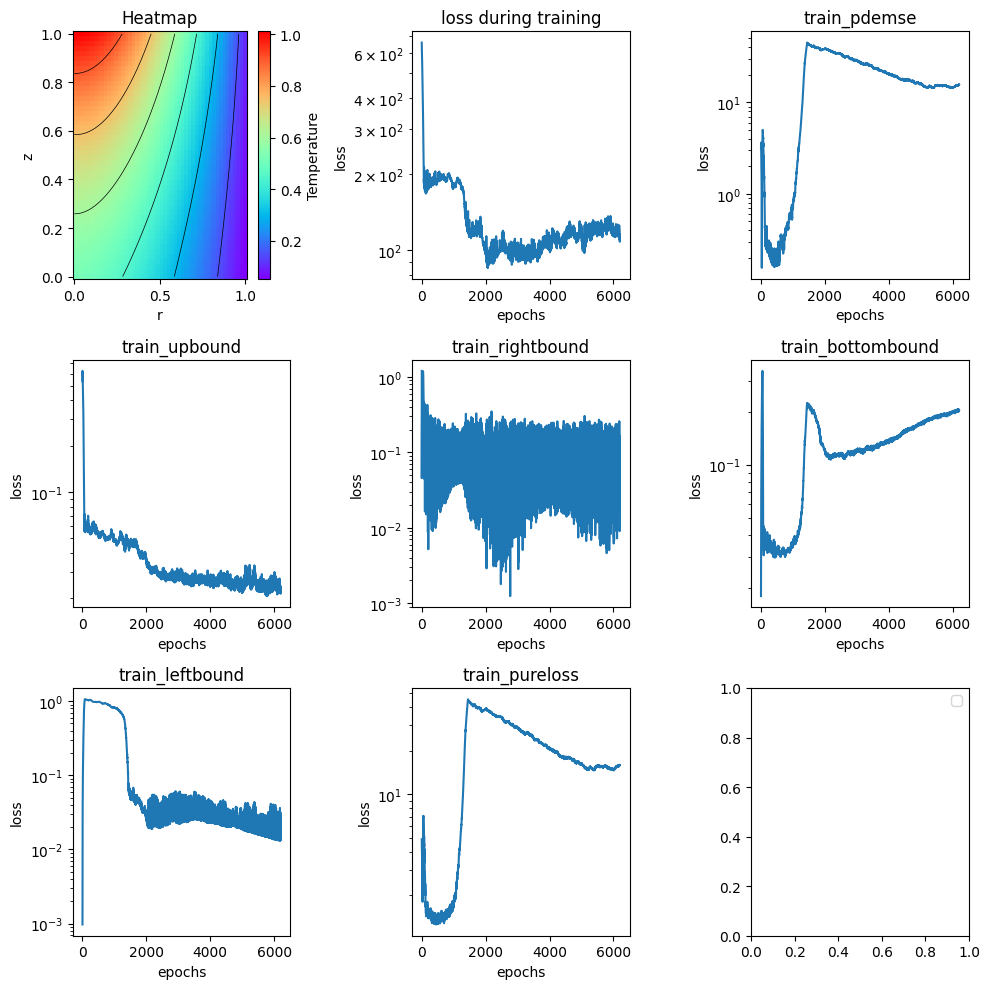

Already calculate for 6360/20000

In [35]:
%matplotlib inline
heat_transfer_2d_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=1024,
    max_epochs=20000,
    shuffle=True,
    metrics=metrics,
    monitor=Monitor2DSpatial(        
        check_on_x=torch.linspace(0.0, 1.0, 50),
        check_on_y=torch.linspace(0.0, 1.0, 50),
        check_every=200,
        device=device
    ),
    device=device
)

In [3]:
solution_xx=torch.linspace(0.0, 1.0, 50)
solution_yy=torch.linspace(0.0, 1.0, 50)

solution_xy_tensor = torch.cartesian_prod(solution_xx, solution_yy)

solution_xx_tensor = torch.squeeze(solution_xy_tensor[:, 0])
solution_yy_tensor = torch.squeeze(solution_xy_tensor[:, 1])

solution_uu_array = fcnn_approximator(solution_xx_tensor, solution_yy_tensor).detach().cpu().numpy()

solution_uu_matrix=solution_uu_array.reshape(len(solution_xx),len(solution_yy)).T

plt.plot(solution_xx,solution_uu_matrix[-1],label="predict")
plt.plot(solution_xx,torch.sin((1-solution_xx)*PI/2),label="exact")
plt.title("Contact interface temperature")
plt.xlabel("r")
plt.ylabel("T")
plt.legend()

plt.show()

NameError: name 'fcnn_approximator' is not defined

In [10]:
import torch
import numpy as np
import pandas as pd

# 生成两个mesh
solution_xx, solution_yy = torch.meshgrid(torch.linspace(0.0, 1.0, 50), torch.linspace(0.0, 1.0, 50))

# 展平两个mesh
solution_xx_flat = (solution_xx*(0.1695-0.135)+0.135).flatten()
solution_yy_flat = (solution_yy*0.02).flatten()

# 将结果转换为 NumPy 数组
solution_data = np.column_stack((solution_xx_flat.numpy(), solution_yy_flat.numpy()))

# 创建 DataFrame
df = pd.DataFrame(solution_data, columns=['R', 'Z'])

# 保存到 txt 文件
df.to_csv('data/solution_data.txt', index=False, sep='\t')  # 使用制表符分隔

# 打印 DataFrame
#print(df)

/Users/yst/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [26]:
fem=pd.read_csv('data/comsol_data_10*sin.txt',delimiter=r'\s+')
solution_xx=torch.linspace(0.0, 1.0, 50)
solution_yy=torch.linspace(0.0, 1.0, 50)

solution_xy_tensor = torch.cartesian_prod(solution_xx, solution_yy)

solution_xx_tensor = torch.squeeze(solution_xy_tensor[:, 0])
solution_yy_tensor = torch.squeeze(solution_xy_tensor[:, 1])

solution_uu_array = fcnn_approximator(solution_xx_tensor, solution_yy_tensor).detach().cpu().numpy()

solution_uu_di_percent=abs(solution_uu_array*maxf+303.15-fem['T'].values)/fem['T'].values*100
solution_uu_di=abs(solution_uu_array*maxf+303.15-fem['T'].values)

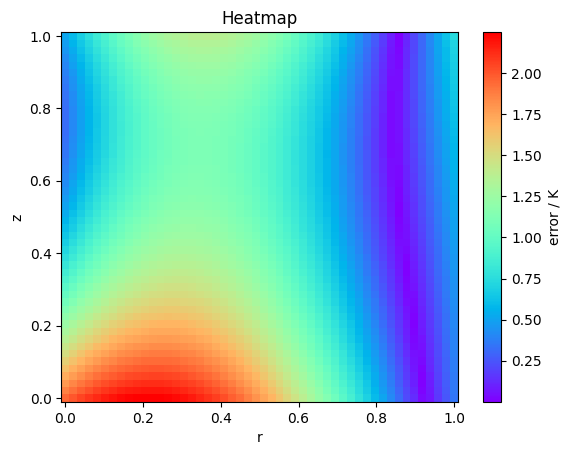

In [27]:
xx, yy = np.meshgrid(solution_xx,solution_yy)
# 创建热力图
heatmap=plt.pcolormesh(xx, yy, solution_uu_di.reshape(xx.shape).T, cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
#contour_lines = plt.contour(xx, yy,solution_uu_array.reshape(xx.shape).T, colors='black', linewidths=0.5,level=15)
# 添加颜色条
cbar=plt.colorbar(heatmap,label='error / K')
# 添加轴标签
plt.xlabel('r')
plt.ylabel('z')
plt.title('Heatmap')
# 显示图形
#plt.legend()
plt.show()